Author: Luca Pappalardo
</br>Geospatial Analytics, Master degree in Data Science and Business Informatics, University of Pisa

# Geospatial Analytics - Lesson 5: Mobility laws and models
- Individual measures
    1. [Jump length](#jumplength)
    2. [Max distance](#maxdistance)
    3. [Distance straight line](#straightline)
    4. [Max distance from home](#distfromhome)
    5. [Radius of gyration](#rg)
    6. [$k$-radius of gyration](#krg)
    7. [Location Frequency](#locfreq)
    8. [Uncorrelated entropy](#uncentropy)
    9. [Individual mobility network](#IMN)
- Collective measures
    1. [Visits per location](#visits_per_location)
    2. [Homes per location](#homes_per_location)
    3. [Visits per time unit](#visits_per_time_unit)
- [Mobility models](#models)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the library
import skmob
import pandas as pd
from tqdm import tqdm
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from stats_utils import *

## Measures
We can compute on a `TrajDataFrame` two types of measures:

- *individual measures*, describing features related to the mobility patterns of a single individual
- *collective measures*, describing the mobility patterns of an entire population of individuals

## Loading the data
We load data of checkins made by users on Brightkite, a location-based social network (LBSN).

The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [3]:
# download the dataset using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=1000000, 
                 names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])
df.head()

,user,check-in_time,latitude,longitude,location id
0,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13T23:31:51Z,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [4]:
# convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
            longitude='longitude', datetime='check-in_time', user_id='user')
print(tdf.shape)
tdf.head()

(1000000, 5)


,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [5]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 2757
number of records:	 1000000


## Individual measures
Computed on the trajectories, quantify standard mobility patterns.

<a id='jumplength'></a>
### Jump lengths
- a jump length is the distance between two consecutive visits of an individual
- given a `TrajDataFrame`, skmob computes the lengths for each individual independently
- use the `jump_lengths` function

In [6]:
from skmob.measures.individual import jump_lengths

In [7]:
jl_df = jump_lengths(tdf) # disable progress bar with show_progress=False
jl_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 493.13it/s]


,uid,jump_lengths
0,0,"[19.64046732887831, 0.0, 0.0, 1.74343110103816..."
1,1,"[6.505330424378811, 46.754366003759536, 53.928..."
2,2,"[0.0, 0.0, 0.0, 0.0, 3.641009719594163, 0.0, 5..."
3,3,"[3861.270630079885, 4.061631313492122, 5.91632..."
4,4,"[15511.92758595804, 0.0, 15511.92758595804, 1...."


In [8]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 478.28it/s]


In [9]:
type(jl_list)

list

In [10]:
len(jl_list)

997243

In [11]:
jl_list[:10]

[19.64046732887831,
 0.0,
 0.0,
 1.743431101038163,
 1553.5011134765616,
 0.0,
 30.14517724008101,
 0.0,
 2.563647571198179,
 1.9309489380903868]

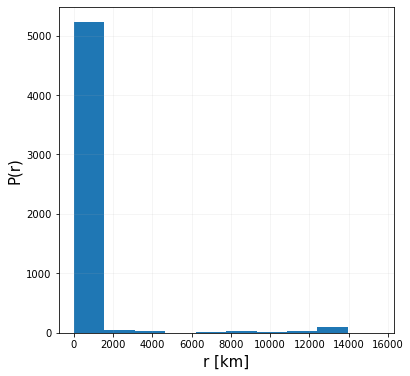

In [12]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(6, 6))
d_list = [dist for dist in jl_list[:10000] if dist >= 1]
plt.hist(d_list)
plt.xlabel('r [km]', fontsize=15)
plt.ylabel('P(r)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

In [13]:
x, y = zip(*lbpdf(1.5, [r for r in jl_list if r > 1.0]))

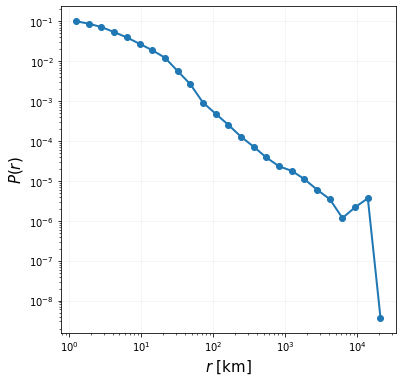

In [14]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('$r$ [km]', fontsize=15)
plt.ylabel('$P(r)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="maxdistance"></a>
### Max distance
- maximum distance traveled by each individual 
- use function `maximum_distance`

In [16]:
from skmob.measures.individual import maximum_distance

In [17]:
md_df = maximum_distance(tdf)
md_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 479.11it/s]


,uid,maximum_distance
0,0,11294.436420
1,1,12804.895064
2,2,11286.745660
3,3,12803.259219
4,4,15511.927586


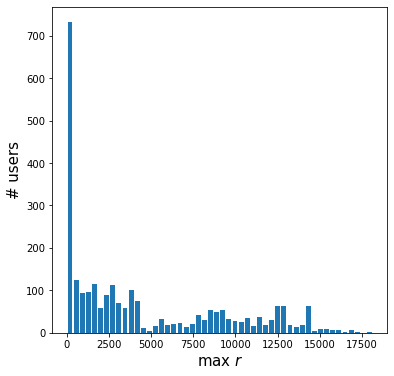

In [18]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
plt.hist(md_df['maximum_distance'], bins=50, rwidth=0.8)
plt.xlabel('max $r$', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [19]:
md_df = md_df[md_df['maximum_distance'] > 1]

In [20]:
x, y = zip(*lbpdf(1.5, list(md_df['maximum_distance'])))

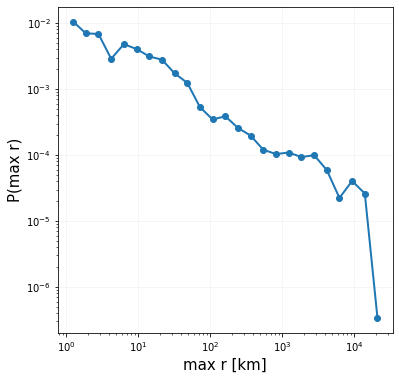

In [21]:
# let's plot the distribution of max distance
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('max r [km]', fontsize=15)
plt.ylabel('P(max r)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="straightline"></a>
### Distance straight line
- distance straight line traveled by each individual
- use function `distance_straight_line`

In [22]:
from skmob.measures.individual import distance_straight_line

In [23]:
dsl_df = distance_straight_line(tdf)
dsl_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 461.32it/s]


,uid,distance_straight_line
0,0,374530.954882
1,1,774346.816009
2,2,88710.682464
3,3,470986.771764
4,4,214623.524252


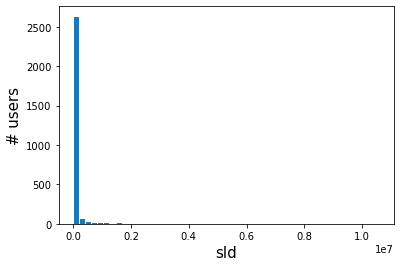

In [24]:
# let's plot the distribution
fig = plt.figure()
plt.hist(dsl_df['distance_straight_line'], bins=50, rwidth=0.8)
plt.xlabel('sld', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [25]:
dsl_df = dsl_df[dsl_df['distance_straight_line'] > 1]

In [26]:
x, y = zip(*lbpdf(1.5, list(dsl_df['distance_straight_line'])))

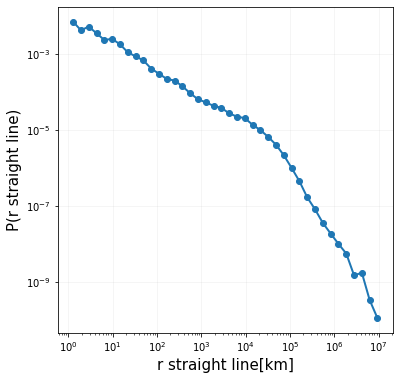

In [27]:
# let's plot the distribution 
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('r straight line[km]', fontsize=15)
plt.ylabel('P(r straight line)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="distfromhome"></a>
### Max distance from home
- compute the maximum distance traveled by an individual from their home
- use the function `max_distance_from_home`

In [28]:
from skmob.measures.individual import max_distance_from_home

In [29]:
mdh_df = max_distance_from_home(tdf)
mdh_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:16<00:00, 165.84it/s]


,uid,max_distance_from_home
0,0,11286.942949
1,1,12800.547682
2,2,11282.748348
3,3,12799.754644
4,4,15512.788707


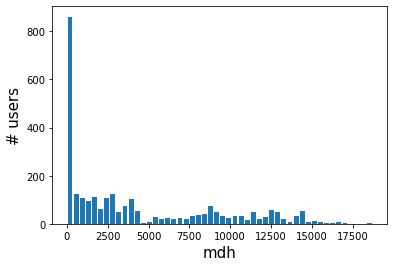

In [30]:
# let's plot the distribution
fig = plt.figure()
plt.hist(mdh_df['max_distance_from_home'], bins=50, rwidth=0.8)
plt.xlabel('mdh', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [31]:
mdh_df = mdh_df[mdh_df['max_distance_from_home'] > 1]

In [32]:
x, y = zip(*lbpdf(1.5, list(mdh_df['max_distance_from_home'])))

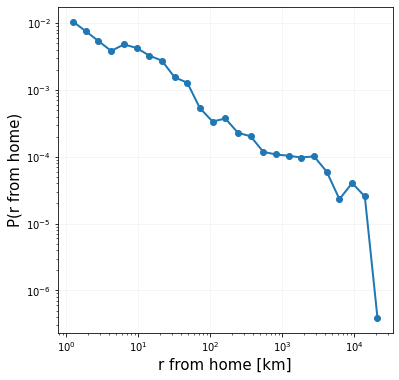

In [33]:
# let's plot the distribution 
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('r from home [km]', fontsize=15)
plt.ylabel('P(r from home)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="rg"></a>
### Radius of gyration $r_g$
characteristic distance traveled by an individual:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ is the position vector of the center of mass of the set of locations visited by the individual

In [34]:
from skmob.measures.individual import radius_of_gyration

In [35]:
rg_df = radius_of_gyration(tdf)
rg_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:04<00:00, 577.93it/s]


,uid,radius_of_gyration
0,0,1564.436792
1,1,2467.773523
2,2,1439.649774
3,3,1752.604191
4,4,5380.503250


In [36]:
type(rg_df)

pandas.core.frame.DataFrame

<AxesSubplot:ylabel='Frequency'>

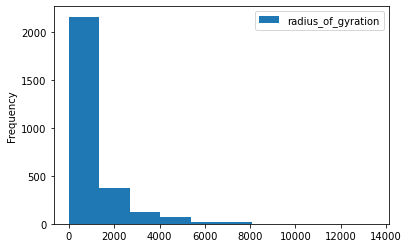

In [37]:
rg_df.plot(kind='hist', y='radius_of_gyration')

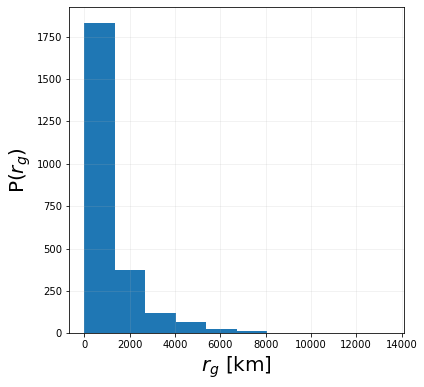

In [38]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
rg_list = list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])
plt.hist(rg_list)
plt.xlabel('$r_g$ [km]', fontsize=20);plt.ylabel('P($r_g$)', fontsize=20)
plt.grid(alpha=0.2)
plt.show()

In [39]:
rg_df = rg_df[rg_df['radius_of_gyration'] > 1]

In [40]:
x, y = zip(*lbpdf(1.5, list(rg_df['radius_of_gyration'])))

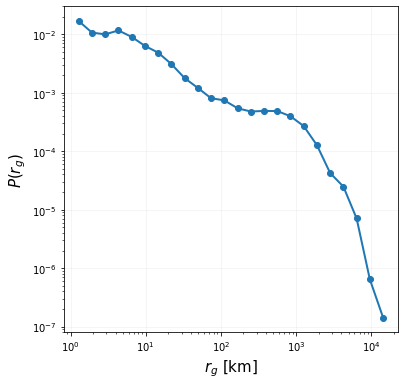

In [41]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$P(r_g)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="krg"></a>
### $k$-radius of gyration $r_g^{(k)}$
recurrent distance traveled by an individual:

$$r_g^{(k)} = \sqrt{\frac{1}{N_k} \sum_{i=1}^k (\mathbf{r}_i - \mathbf{r}_{cm}^{(k)})^2}$$

$r_{cm}^{(k)}$ is the position vector of the center of mass of the set $k$ most visited locations

In [42]:
from skmob.measures.individual import k_radius_of_gyration

In [43]:
krg_df = k_radius_of_gyration(tdf)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:12<00:00, 221.70it/s]


In [44]:
krg_df.head()

,uid,2k_radius_of_gyration
0,0,7.858833
1,1,4.069300
2,2,5.878727
3,3,10.622092
4,4,0.740360


In [45]:
rgs_df = pd.merge(rg_df, krg_df, on='uid')
rgs_df.head()

,uid,radius_of_gyration,2k_radius_of_gyration
0,0,1564.436792,7.858833
1,1,2467.773523,4.069300
2,2,1439.649774,5.878727
3,3,1752.604191,10.622092
4,4,5380.503250,0.740360


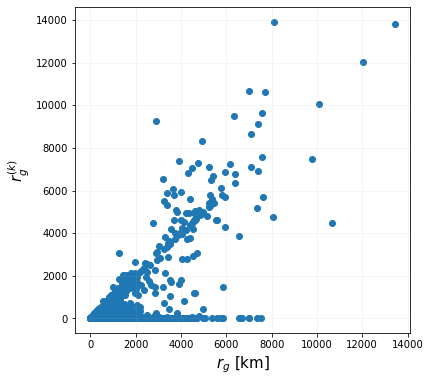

In [46]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(rgs_df['radius_of_gyration'], rgs_df['2k_radius_of_gyration'], marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id='locfreq'></a>
### Location frequency
- compute the frequency of visiting each location
- use the function `location_frequency`

In [47]:
from skmob.measures.individual import location_frequency

In [48]:
lf_df = location_frequency(tdf, normalize=True).reset_index()
lf_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 535.26it/s]


,uid,lat,lng,location_frequency
0,0,39.762146,-104.982480,0.101953
1,0,39.891077,-105.068532,0.065269
2,0,39.739154,-104.984703,0.060029
3,0,39.891586,-105.068463,0.034302
4,0,39.827022,-105.143191,0.025250


In [49]:
a_user_lf_df = lf_df[lf_df['uid'] == 1]
a_user_lf_df.head()

,uid,lat,lng,location_frequency
542,1,37.630490,-122.411084,0.245455
543,1,37.580304,-122.343679,0.222314
544,1,37.584103,-122.366083,0.205785
545,1,37.613825,-122.486919,0.041322
546,1,0.000000,0.000000,0.038017


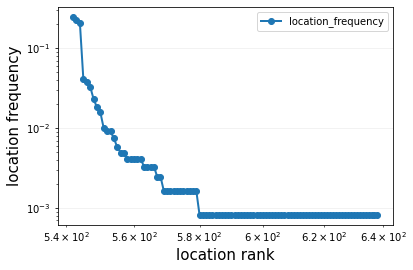

In [50]:
a_user_lf_df.plot(y='location_frequency', linewidth=2, marker='o')
plt.loglog()
plt.xlabel('location rank', fontsize=15)
plt.ylabel('location frequency', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

In [51]:
new_lf_df = location_frequency(tdf, as_ranks=True)
type(new_lf_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 547.64it/s]


list

(array([1.266e+03, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00047619, 0.0387778 , 0.07707941, 0.11538102, 0.15368263,
        0.19198424, 0.23028585, 0.26858747, 0.30688908, 0.34519069,
        0.3834923 ]),
 <BarContainer object of 10 artists>)

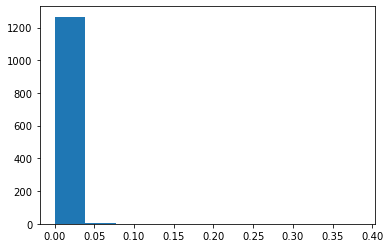

In [52]:
plt.hist(new_lf_df)
plt.show()

<a id="uncentropy"></a>
### Uncorrelated entropy

The predictability of an individual considering the spatial dimension only:

$$ S^{unc} = - \sum_{i=1}^N p_i \log_2(p_i)$$

In [53]:
from skmob.measures.individual import uncorrelated_entropy

In [54]:
s_unc_df = uncorrelated_entropy(tdf, normalize=True)
s_unc_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:08<00:00, 344.24it/s]


,uid,norm_uncorrelated_entropy
0,0,0.819430
1,1,0.552972
2,2,0.764304
3,3,0.794553
4,4,0.756421


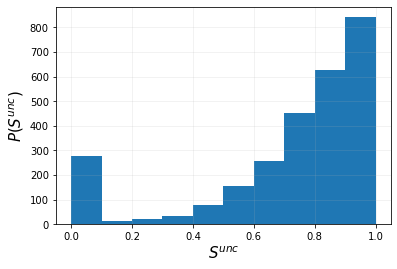

In [55]:
plt.hist(s_unc_df['norm_uncorrelated_entropy'])
plt.xlabel('$S^{unc}$', fontsize=15)
plt.ylabel('$P(S^{unc})$', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

<a id="IMN"></a>
### Individual mobility network
it is a network where:

- nodes represent locations visited by the individual
- directed edges represent trips between the locations made by the individual

In [56]:
from skmob.measures.individual import individual_mobility_network

In [57]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 397.75it/s]


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,0,37.774929,-122.419415,37.600747,-122.382376,1
1,0,37.600747,-122.382376,37.615223,-122.389979,1
2,0,37.600747,-122.382376,37.580304,-122.343679,1
3,0,37.615223,-122.389979,39.878664,-104.682105,1
4,0,37.615223,-122.389979,37.580304,-122.343679,1


In [58]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.sort_values(by='n_trips', ascending=False).head()

,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
1686,2,39.758302,-104.936129,39.802002,-105.095430,69
1452,2,39.802002,-105.095430,39.758302,-104.936129,59
1493,2,39.739154,-104.984703,39.802002,-105.095430,52
1446,2,39.802002,-105.095430,39.739154,-104.984703,51
1535,2,39.739154,-104.984703,39.818040,-105.081949,23


In [59]:
import networkx as nx
from tqdm import tqdm

In [60]:
a_user_imn_df = imn_df[imn_df['uid'] == 3]
print(len(a_user_imn_df))
a_user_imn_df.head()

1054


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
2413,3,29.894691,-81.314517,37.758839,-122.388345,1
2414,3,29.894691,-81.314517,29.800407,-81.319127,1
2415,3,37.758839,-122.388345,37.795105,-122.393861,1
2416,3,37.795105,-122.393861,37.752539,-122.434248,1
2417,3,37.795105,-122.393861,37.806327,-122.405041,1


In [61]:
g = nx.DiGraph()

In [62]:
for i, row in a_user_imn_df.iterrows():
    origin = (row['lat_origin'], row['lng_origin'])
    destination = (row['lat_dest'], row['lng_dest'])
    g.add_edge(origin, destination, weight=row['n_trips'])

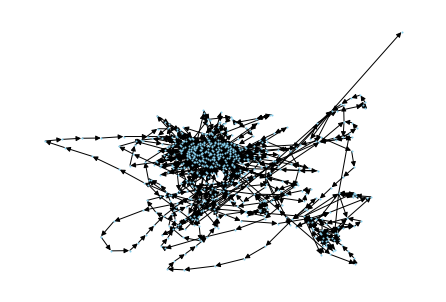

In [63]:
nx.draw(g, node_size=1, node_color="skyblue")

You may custommize the visualization of the network: https://www.python-graph-gallery.com/321-custom-networkx-graph-appearance

## Collective measures
are computed on the trajectories of all individual together and quantify standard collective mobility patterns

<a id="visits_per_location"></a>
### Visits per location
number of visits to a location made by the population of individuals

In [64]:
from skmob.measures.collective import visits_per_location

In [65]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,0.000000,0.000000,20397
1,39.739154,-104.984703,11949
2,40.014986,-105.270546,5893
3,37.774929,-122.419415,4993
4,40.714269,-74.005973,3626


Text(0.5, 0, 'number of visits')

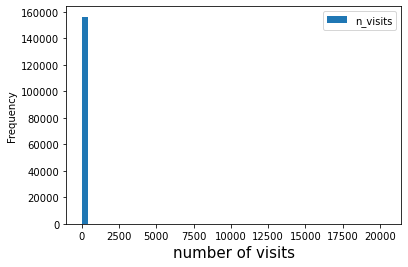

In [66]:
vpl_df.plot(kind='hist', y='n_visits', bins=50)
plt.xlabel('number of visits', fontsize=15)

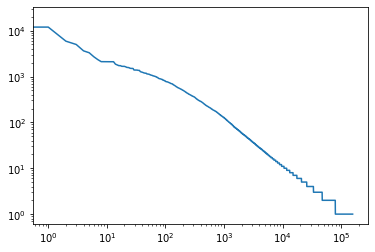

In [67]:
vpl_df['n_visits'].plot()
plt.loglog()
plt.show()

<a id="homes_per_location"></a>
### Homes per location
Compute the number of home locations in each location 

In [68]:
from skmob.measures.collective import homes_per_location

In [69]:
hpl_df = homes_per_location(tdf)
hpl_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 395.79it/s]


,lat,lng,n_homes
0,39.739154,-104.984703,99
1,40.014986,-105.270546,51
2,37.774929,-122.419415,46
3,0.000000,0.000000,44
4,30.267153,-97.743061,23


<AxesSubplot:ylabel='Frequency'>

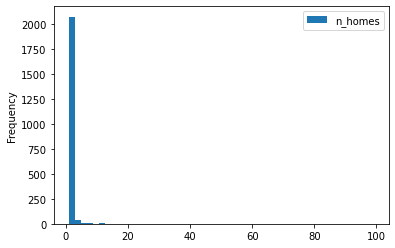

In [70]:
hpl_df.plot(kind='hist', y='n_homes', bins=50)

<a id="visits_per_time_unit"></a>
### Visits per time unit

In [71]:
from skmob.measures.collective import visits_per_time_unit

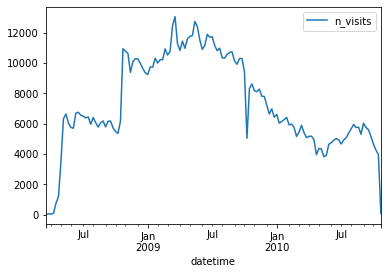

In [75]:
visits_per_time_unit(tdf, time_unit='1w').plot()
plt.show()

<a id="models"></a>
## Mobility models